# Libraries and Helper Functions

In [3]:
import pandas as pd
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation

In [4]:
def model_evaluation(X, y, model, label):
    predictions = model.predict(X)
    accuracy = accuracy_score(y, predictions)
    print('{0} Accuracy: {1:.4f}'.format(label, accuracy))
    cm = confusion_matrix(y, predictions)
    cm = cm.astype('float') / cm.sum(axis=1)
    df_cm = pd.DataFrame(cm, index = sorted(y.unique()), columns = sorted(y.unique()))
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, fmt='.3f', cmap='Blues')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [5]:
def get_feature_importance(model, X_train):
    feature_importance = model.feature_importances_
    indices = np.argsort(feature_importance)[::-1]
    feature_importance = [feature_importance[i] for i in indices]
    predictors = X_train.columns
    predictors = [predictors[i] for i in indices]
    predictors_index = range(1, len(predictors) + 1)
    num_features = X_train.shape[1]
    #num_features = len(predictors) if num_features is None else num_features
    plt.figure(figsize=(20,20))
    plt.bar(predictors_index[:num_features], feature_importance[:num_features], align = 'center')
    plt.xticks(predictors_index[:num_features], predictors[:num_features], rotation = 'vertical')
    plt.show()

In [6]:
# load and clean data
train_df = pd.read_csv('train_w_cluster.csv')
test_df = pd.read_csv('test_w_cluster.csv')
train_df['vote_count'] = train_df['vote_count'].apply(lambda x: int(x.replace('[', '').replace(']', '')))

In [7]:
# create dummy columns and remove string variables
columns_to_remove = ['overview', 'tagline', 'plot', 'plot outline', 'mpaa_rating_text', 'id']
dummy_columns = ['mpaa_rating', 'overview_cluster', 'tagline_cluster', 'plot_cluster', 'plot outline_cluster', 'mpaa_rating_text_cluster']
for column in dummy_columns:
    train_df = pd.concat([train_df, pd.get_dummies(train_df[column], prefix = column, prefix_sep = '_')], axis=1)
    test_df = pd.concat([test_df, pd.get_dummies(test_df[column], prefix = column, prefix_sep = '_')], axis=1)
train_df = train_df.drop(columns_to_remove + dummy_columns, axis = 1)
test_df = test_df.drop(columns_to_remove + dummy_columns, axis = 1)

In [10]:
test_df.head(5)

,part_of_collection,budget,popularity,production_companies,release_month,release_year,revenue,runtime,spoken_languages,vote_average,...,mpaa_rating_text_cluster_0,mpaa_rating_text_cluster_1,mpaa_rating_text_cluster_2,mpaa_rating_text_cluster_3,mpaa_rating_text_cluster_4,mpaa_rating_text_cluster_5,mpaa_rating_text_cluster_6,mpaa_rating_text_cluster_7,mpaa_rating_text_cluster_8,mpaa_rating_text_cluster_9
0,False,0,0.188719,0,9,2006,0,132.0,1,7.2,...,0,0,1,0,0,0,0,0,0,0
1,True,4000000,0.696750,2,11,1981,125728258,94.0,1,6.1,...,0,0,1,0,0,0,0,0,0,0
2,False,0,0.157579,1,4,1995,0,105.0,1,7.0,...,0,0,1,0,0,0,0,0,0,0
3,False,0,0.162032,2,3,1996,0,135.0,1,5.5,...,0,0,1,0,0,0,0,0,0,0
4,False,48000000,1.556948,5,12,2000,207515725,148.0,2,6.9,...,0,0,1,0,0,0,0,0,0,0


In [11]:
print(train_df.shape)
print(test_df.shape)

(9208, 75)
(3947, 75)


In [12]:
X_train = train_df.drop('genre', axis = 1)
y_train = train_df['genre']
X_test = test_df.drop('genre', axis = 1)
y_test = test_df['genre']

# Use All Features

### Default Param Model

Train Accuracy: 0.5143


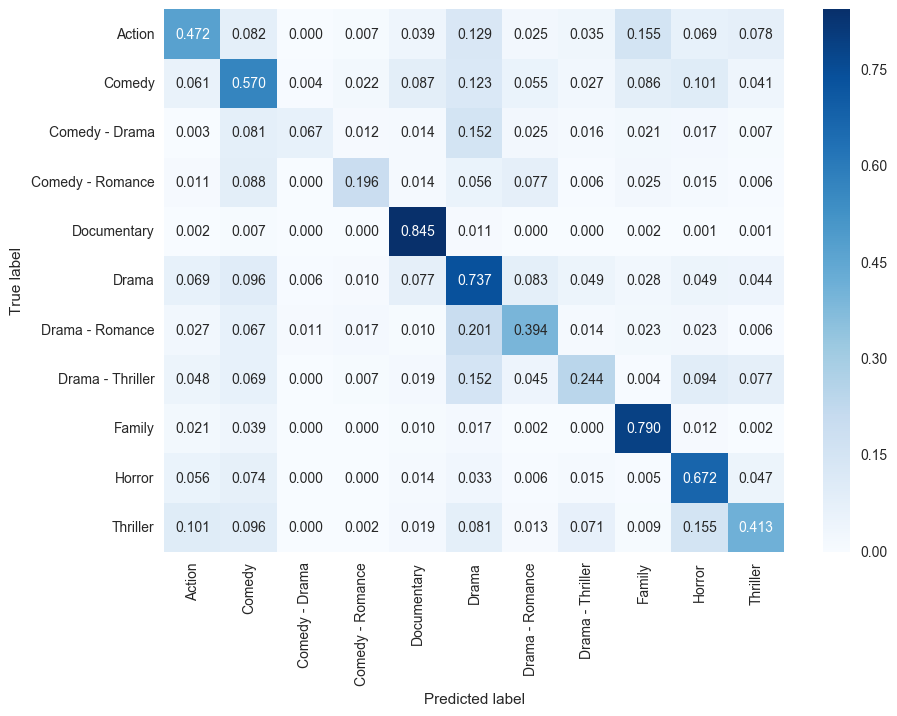

In [16]:
base_model = XGBClassifier()
base_model.fit(X_train, y_train)
model_evaluation(X_train, y_train, base_model, 'Train')

### First Tune max_depth and min_child_weight

In [17]:
# parameter definitions
'''
max_depth : int
Maximum tree depth for base learners.
learning_rate : float
Boosting learning rate (xgb’s “eta”)
n_estimators : int
Number of boosted trees to fit.
silent : boolean
Whether to print messages while running boosting.
objective : string or callable
Specify the learning task and the corresponding learning objective or a custom objective function to be used (see note below).
nthread : int
Number of parallel threads used to run xgboost.
gamma : float
Minimum loss reduction required to make a further partition on a leaf node of the tree.
min_child_weight : int
Minimum sum of instance weight(hessian) needed in a child.
max_delta_step : int
Maximum delta step we allow each tree’s weight estimation to be.
subsample : float
Subsample ratio of the training instance.
colsample_bytree : float
Subsample ratio of columns when constructing each tree.
colsample_bylevel : float
Subsample ratio of columns for each split, in each level.
reg_alpha : float (xgb’s alpha)
L1 regularization term on weights
reg_lambda : float (xgb’s lambda)
L2 regularization term on weights
scale_pos_weight : float
Balancing of positive and negative weights.
base_score:
The initial prediction score of all instances, global bias.
seed : int
Random number seed.
'''
model_a = XGBClassifier()
XGB_PARAMETERS = {'max_depth': range(3,10,2), 'min_child_weight': range(0,6,2)}
model_a_cv = GridSearchCV(model_a, XGB_PARAMETERS, scoring = "f1_weighted", cv = 5)
model_a_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 5, 7, 9], 'min_child_weight': [0, 2, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1_weighted',
       verbose=0)

In [18]:
model_a_cv.grid_scores_, model_a_cv.best_params_, model_a_cv.best_score_

([mean: 0.39729, std: 0.00568, params: {'max_depth': 3, 'min_child_weight': 0},
  mean: 0.39726, std: 0.00449, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: 0.39762, std: 0.00636, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: 0.40946, std: 0.00566, params: {'max_depth': 5, 'min_child_weight': 0},
  mean: 0.40820, std: 0.00560, params: {'max_depth': 5, 'min_child_weight': 2},
  mean: 0.40644, std: 0.00799, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: 0.40595, std: 0.00649, params: {'max_depth': 7, 'min_child_weight': 0},
  mean: 0.40618, std: 0.00270, params: {'max_depth': 7, 'min_child_weight': 2},
  mean: 0.40853, std: 0.00598, params: {'max_depth': 7, 'min_child_weight': 4},
  mean: 0.39753, std: 0.00409, params: {'max_depth': 9, 'min_child_weight': 0},
  mean: 0.40337, std: 0.00557, params: {'max_depth': 9, 'min_child_weight': 2},
  mean: 0.40613, std: 0.00618, params: {'max_depth': 9, 'min_child_weight': 4}],
 {'max_depth': 5, 'min_child_weight': 0

### Second: Tune gamma

In [28]:
model_b = XGBClassifier()
XGB_PARAMETERS = {k:[v] for k,v in model_a_cv.best_params_.items()}.copy()
XGB_PARAMETERS.update({'gamma': [i/10.0 for i in range(0,5)]})
print XGB_PARAMETERS
model_b_cv = GridSearchCV(model_b, XGB_PARAMETERS, scoring = "f1_weighted", cv = 5)
model_b_cv.fit(X_train, y_train)
model_b_cv.grid_scores_, model_b_cv.best_params_, model_b_cv.best_score_

{'gamma': [0.0, 0.1, 0.2, 0.3, 0.4], 'max_depth': [5], 'min_child_weight': [0]}


([mean: 0.40946, std: 0.00566, params: {'max_depth': 5, 'gamma': 0.0, 'min_child_weight': 0},
  mean: 0.40935, std: 0.00570, params: {'max_depth': 5, 'gamma': 0.1, 'min_child_weight': 0},
  mean: 0.41429, std: 0.00634, params: {'max_depth': 5, 'gamma': 0.2, 'min_child_weight': 0},
  mean: 0.41098, std: 0.00619, params: {'max_depth': 5, 'gamma': 0.3, 'min_child_weight': 0},
  mean: 0.40966, std: 0.00589, params: {'max_depth': 5, 'gamma': 0.4, 'min_child_weight': 0}],
 {'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 0},
 0.41428918983909874)

### Third: Tune subsample and colsample_bytree

In [40]:
print 2+2
model_c = XGBClassifier()
XGB_PARAMETERS = {k:[v] for k,v in model_b_cv.best_params_.items()}.copy()
XGB_PARAMETERS.update({'subsample':[i/10.0 for i in range(6,10)],
                       'colsample_bytree':[i/10.0 for i in range(6,10)]})
model_c_cv = GridSearchCV(model_c, XGB_PARAMETERS, scoring = "f1_weighted", cv = 5)
model_c_cv.fit(X_train, y_train)
model_c_cv.grid_scores_, model_c_cv.best_params_, model_c_cv.best_score_

4


([mean: 0.40810, std: 0.00663, params: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 5, 'gamma': 0.2, 'min_child_weight': 0},
  mean: 0.41452, std: 0.00725, params: {'subsample': 0.7, 'colsample_bytree': 0.6, 'max_depth': 5, 'gamma': 0.2, 'min_child_weight': 0},
  mean: 0.40852, std: 0.00828, params: {'subsample': 0.8, 'colsample_bytree': 0.6, 'max_depth': 5, 'gamma': 0.2, 'min_child_weight': 0},
  mean: 0.40869, std: 0.00609, params: {'subsample': 0.9, 'colsample_bytree': 0.6, 'max_depth': 5, 'gamma': 0.2, 'min_child_weight': 0},
  mean: 0.41171, std: 0.00510, params: {'subsample': 0.6, 'colsample_bytree': 0.7, 'max_depth': 5, 'gamma': 0.2, 'min_child_weight': 0},
  mean: 0.41257, std: 0.00889, params: {'subsample': 0.7, 'colsample_bytree': 0.7, 'max_depth': 5, 'gamma': 0.2, 'min_child_weight': 0},
  mean: 0.40957, std: 0.00208, params: {'subsample': 0.8, 'colsample_bytree': 0.7, 'max_depth': 5, 'gamma': 0.2, 'min_child_weight': 0},
  mean: 0.40926, std: 0.00629, params: {'

### Fourth: Tune regularization params 10:49am

In [41]:
model_d = XGBClassifier()
XGB_PARAMETERS = {k:[v] for k,v in model_c_cv.best_params_.items()}.copy()
XGB_PARAMETERS.update({'reg_alpha':[1e-5, 1e-3, 0.1, 1, 10, 100]})
model_d_cv = GridSearchCV(model_d, XGB_PARAMETERS, scoring = "f1_weighted", cv = 5)
model_d_cv.fit(X_train, y_train)
model_d_cv.grid_scores_, model_d_cv.best_params_, model_d_cv.best_score_

([mean: 0.41457, std: 0.00644, params: {'reg_alpha': 1e-05, 'colsample_bytree': 0.9, 'min_child_weight': 0, 'subsample': 0.6, 'max_depth': 5, 'gamma': 0.2},
  mean: 0.41111, std: 0.00759, params: {'reg_alpha': 0.001, 'colsample_bytree': 0.9, 'min_child_weight': 0, 'subsample': 0.6, 'max_depth': 5, 'gamma': 0.2},
  mean: 0.41466, std: 0.00712, params: {'reg_alpha': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 0, 'subsample': 0.6, 'max_depth': 5, 'gamma': 0.2},
  mean: 0.40947, std: 0.01093, params: {'reg_alpha': 1, 'colsample_bytree': 0.9, 'min_child_weight': 0, 'subsample': 0.6, 'max_depth': 5, 'gamma': 0.2},
  mean: 0.40132, std: 0.01068, params: {'reg_alpha': 10, 'colsample_bytree': 0.9, 'min_child_weight': 0, 'subsample': 0.6, 'max_depth': 5, 'gamma': 0.2},
  mean: 0.24988, std: 0.00297, params: {'reg_alpha': 100, 'colsample_bytree': 0.9, 'min_child_weight': 0, 'subsample': 0.6, 'max_depth': 5, 'gamma': 0.2}],
 {'colsample_bytree': 0.9,
  'gamma': 0.2,
  'max_depth': 5,
  'min_

In [43]:
model_d2 = XGBClassifier()
XGB_PARAMETERS = {k:[v] for k,v in model_d_cv.best_params_.items()}.copy()
XGB_PARAMETERS.update({'reg_alpha':[.01, .05, 0.1, .3, .5, .75]})
model_d2_cv = GridSearchCV(model_d2, XGB_PARAMETERS, scoring = "f1_weighted", cv = 5, verbose = 100)
model_d2_cv.fit(X_train, y_train)
model_d2_cv.grid_scores_, model_d2_cv.best_params_, model_d2_cv.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] reg_alpha=0.01, colsample_bytree=0.9, min_child_weight=0, subsample=0.6, max_depth=5, gamma=0.2 
[CV]  reg_alpha=0.01, colsample_bytree=0.9, min_child_weight=0, subsample=0.6, max_depth=5, gamma=0.2, score=0.416472 -  34.8s
[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:   34.8s
[CV] reg_alpha=0.01, colsample_bytree=0.9, min_child_weight=0, subsample=0.6, max_depth=5, gamma=0.2 
[CV]  reg_alpha=0.01, colsample_bytree=0.9, min_child_weight=0, subsample=0.6, max_depth=5, gamma=0.2, score=0.395374 -  38.2s
[Parallel(n_jobs=1)]: Done   2 tasks       | elapsed:  1.2min
[CV] reg_alpha=0.01, colsample_bytree=0.9, min_child_weight=0, subsample=0.6, max_depth=5, gamma=0.2 
[CV]  reg_alpha=0.01, colsample_bytree=0.9, min_child_weight=0, subsample=0.6, max_depth=5, gamma=0.2, score=0.411594 -  41.0s
[Parallel(n_jobs=1)]: Done   3 tasks       | elapsed:  1.9min
[CV] reg_alpha=0.01, colsample_bytree=0.9, min_child_weight=0, subs

([mean: 0.41117, std: 0.00821, params: {'reg_alpha': 0.01, 'colsample_bytree': 0.9, 'min_child_weight': 0, 'subsample': 0.6, 'max_depth': 5, 'gamma': 0.2},
  mean: 0.41185, std: 0.00784, params: {'reg_alpha': 0.05, 'colsample_bytree': 0.9, 'min_child_weight': 0, 'subsample': 0.6, 'max_depth': 5, 'gamma': 0.2},
  mean: 0.41466, std: 0.00712, params: {'reg_alpha': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 0, 'subsample': 0.6, 'max_depth': 5, 'gamma': 0.2},
  mean: 0.41069, std: 0.00982, params: {'reg_alpha': 0.3, 'colsample_bytree': 0.9, 'min_child_weight': 0, 'subsample': 0.6, 'max_depth': 5, 'gamma': 0.2},
  mean: 0.41387, std: 0.00896, params: {'reg_alpha': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 0, 'subsample': 0.6, 'max_depth': 5, 'gamma': 0.2},
  mean: 0.41058, std: 0.00453, params: {'reg_alpha': 0.75, 'colsample_bytree': 0.9, 'min_child_weight': 0, 'subsample': 0.6, 'max_depth': 5, 'gamma': 0.2}],
 {'colsample_bytree': 0.9,
  'gamma': 0.2,
  'max_depth': 5,
  'mi

### Fifth: Reduce Learning Rate, Add More Tree

In [59]:
model_final = XGBClassifier(
    learning_rate = 0.1,
    n_estimators = 1000,
    colsample_bytree = 0.9,
    gamma = 0.2,
    max_depth = 5,
    min_child_weight = 0,
    reg_alpha =0.1,
    subsample = 0.6)
print "here"
model_final.fit(X_train, y_train, verbose = 100)

here


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0.2, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=0, missing=None, n_estimators=1000, nthread=-1,
       objective='multi:softprob', reg_alpha=0.1, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.6)

### Evaluate Model

Train Accuracy: 1.0000


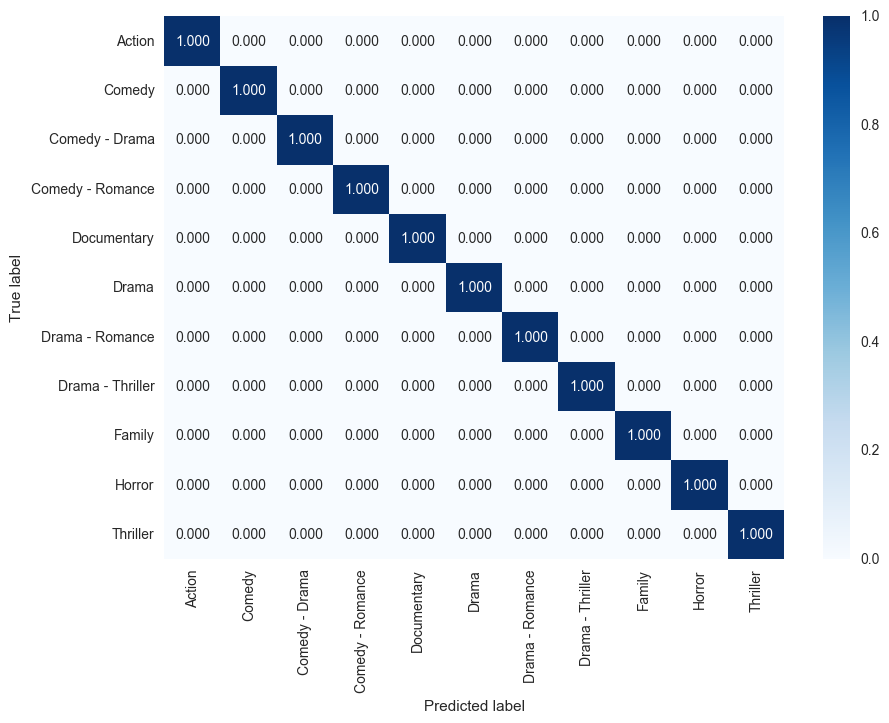

Test Accuracy: 0.4097


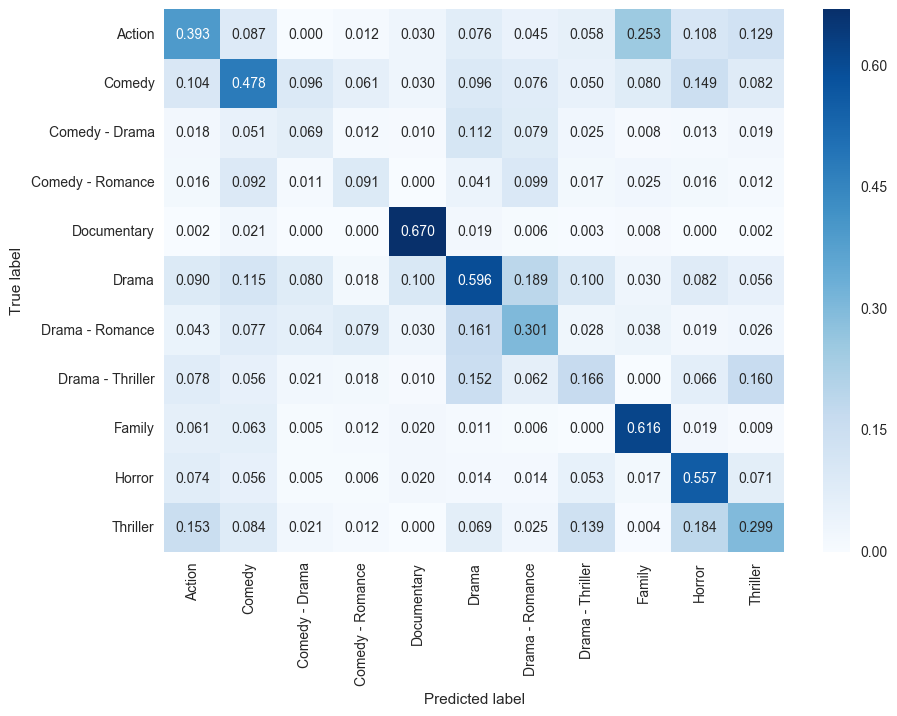

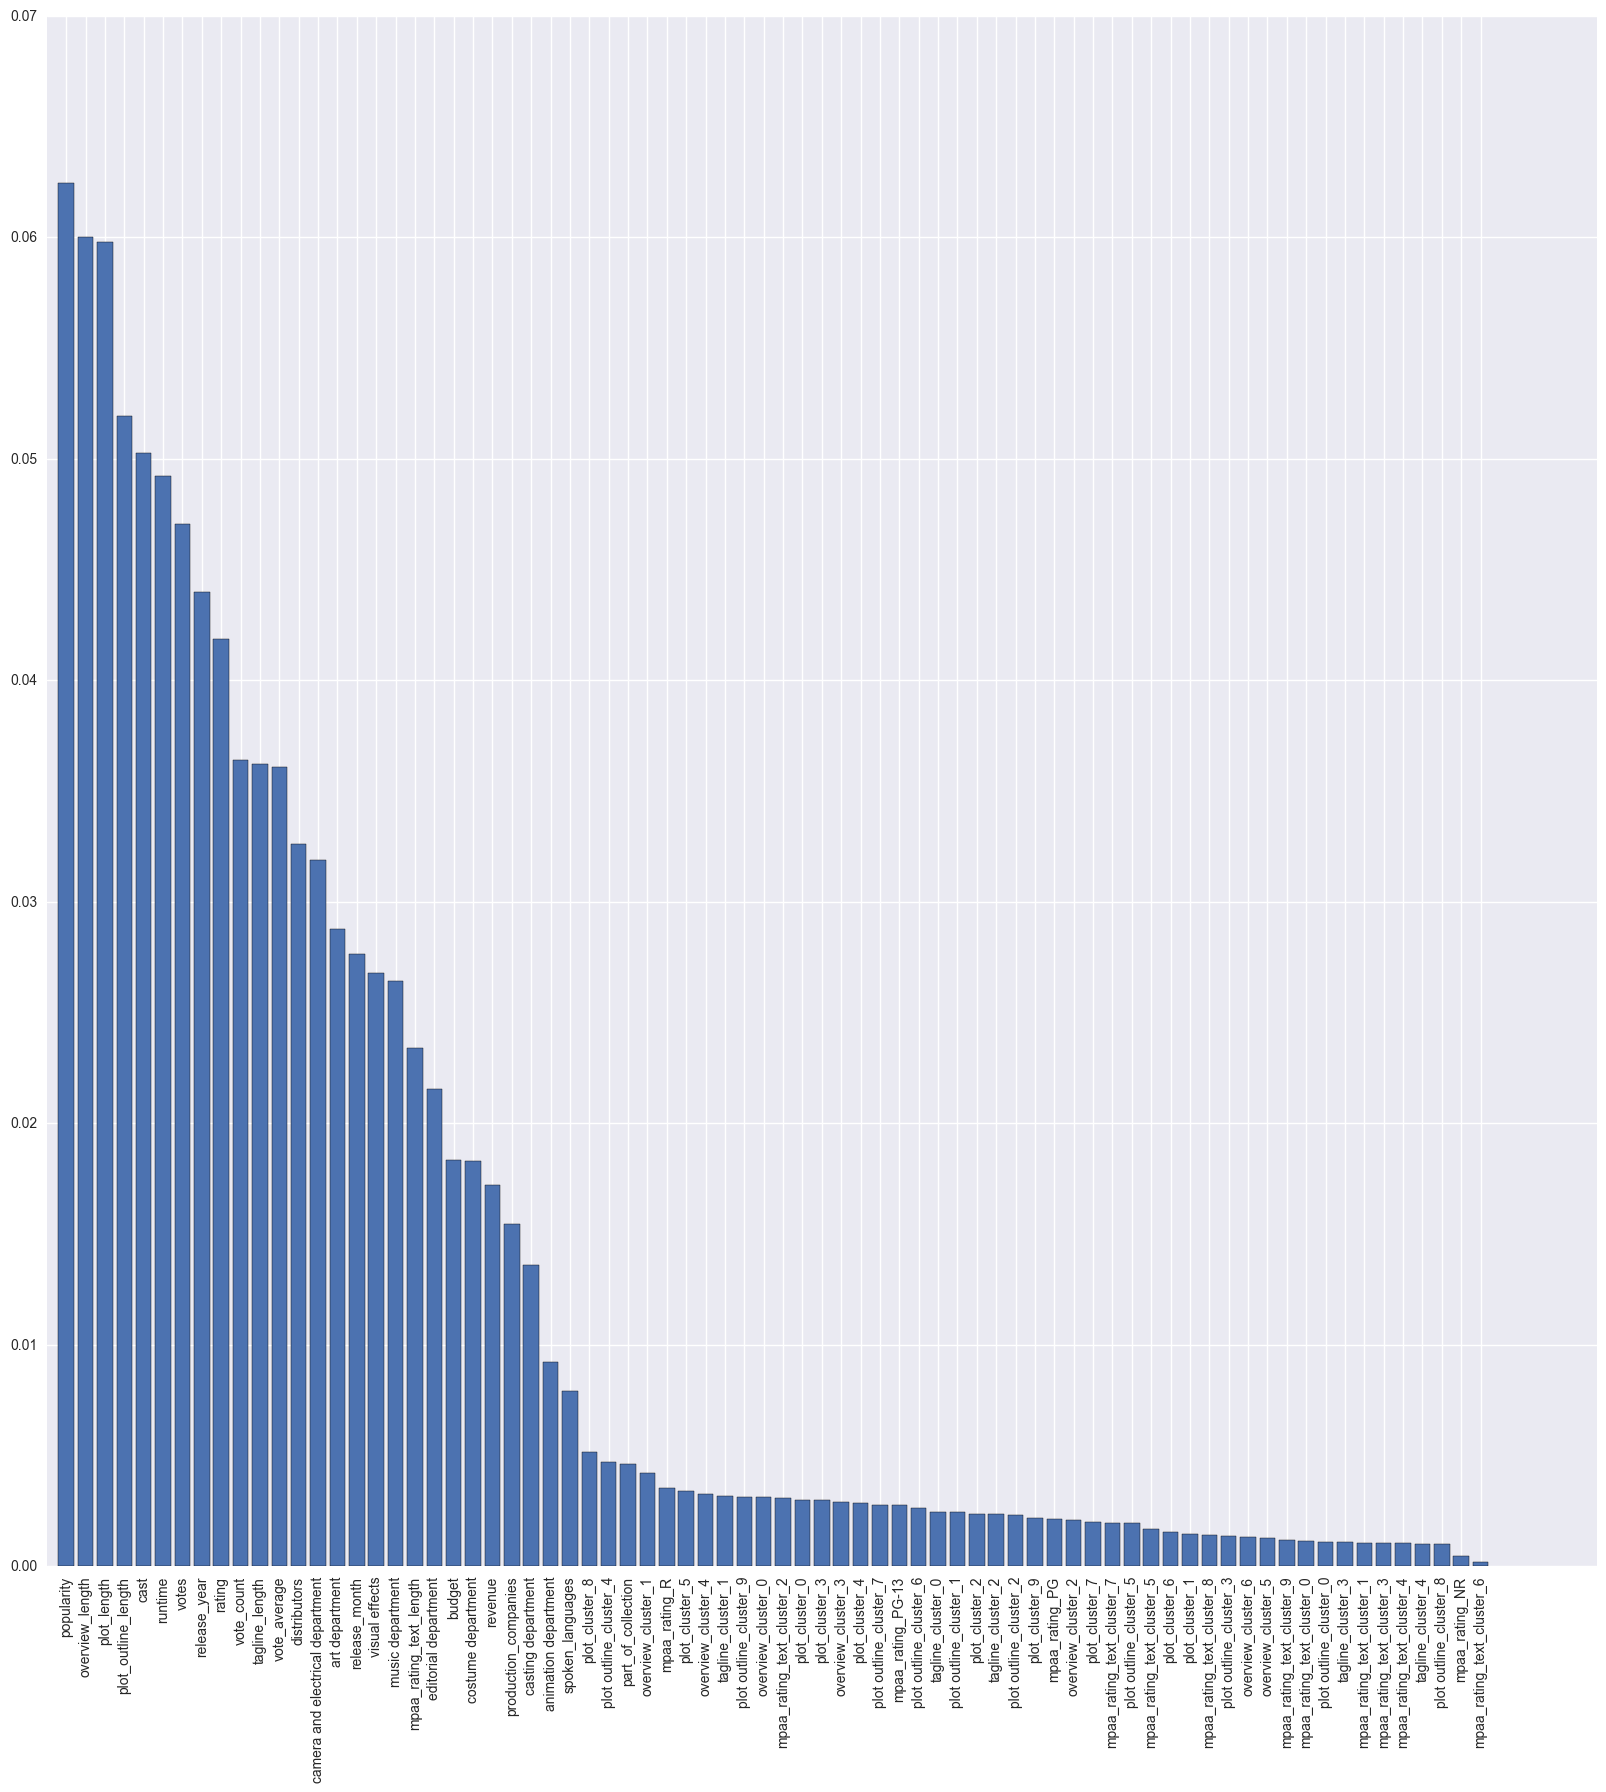

In [60]:
model_evaluation(X_train, y_train, model_final, 'Train')
model_evaluation(X_test, y_test, model_final, 'Test')
get_feature_importance(model_final, X_train)

The final test accuracy is 41%.

In [67]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
predictions = model_final.predict(X_test)
ps = precision_score(y_test, predictions, average='weighted')
print "Precision score is ", ps
rs = recall_score(y_test, predictions, average='weighted')
print "Recall score is ", rs

Precision score is  0.389969764829
Recall score is  0.409678236635
